In [24]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys


from src import SingleAgent as sa
from src import helperfunctions as hf

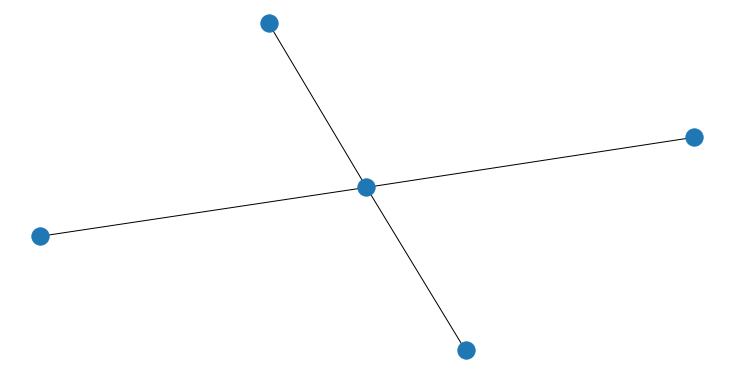

In [43]:
G = nx.star_graph(4)
h = np.zeros(len(G.nodes.keys()))


nx.draw(G)

In [44]:
        
                
budget=1.0
h = np.zeros(len(G.nodes.keys()))

system = sa.mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=int(5*1e4))
beta_crit=hf.crit_b(system.adj_matrix)




In [71]:
exp_beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=100)
iters=10
runs =np.zeros((iters,len(exp_beta_list),system.graph_size))

for run in range(runs.shape[0]):
    control_history=[]
    for i,beta in enumerate(exp_beta_list):
        system = sa.mf_ising_system(G,h,iim_iter=1000,fp_tol_fac=10-4)
        control,_=system.MF_IIM(budget,beta)
        control_history.append(control)
        if i%100==0:
            print(i,beta)
        runs[run,i,:]=control

        
mean_run = np.mean(runs,axis=0)
var_run = np.var(runs,axis=0)
print('FINISHED')    

0 0.19952623149688797
0 0.19952623149688797
0 0.19952623149688797
0 0.19952623149688797
0 0.19952623149688797
0 0.19952623149688797
0 0.19952623149688797
0 0.19952623149688797
0 0.19952623149688797
0 0.19952623149688797
FINISHED


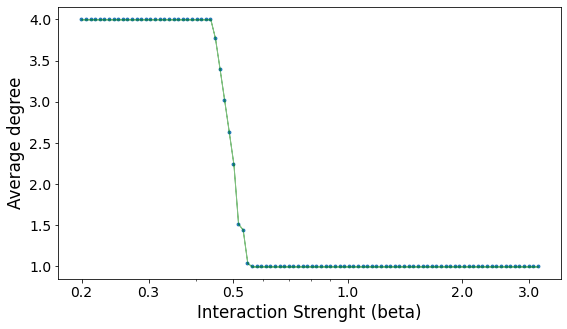

In [72]:


import matplotlib


avs_deg=np.zeros(len(mean_run))
var_deg = np.zeros(len(mean_run))
for it,control in enumerate(mean_run):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    variance_degree = np.sum([G.degree[i]**2*var for i,var in enumerate(var_run[it])])
    avs_deg[it]=average_degree
    var_deg[it]=variance_degree

fig,ax = plt.subplots(figsize=(9,5))

ax.scatter(exp_beta_list,avs_deg,s=8)
ax.set_xscale(value='log')
ax.fill_between(exp_beta_list, avs_deg-np.sqrt(var_deg), avs_deg+np.sqrt(var_deg),
                    **{'color':'green','alpha':0.5})


ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght (beta)')
plt.show()


In [57]:
from itertools import permutations
from functools import reduce
from torch.autograd import grad
import torch


class TrueSolution:

    def __init__(self,graph,init_mag='random',mu=2.0):
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        if init_mag =='aligned':
            self.init_mag = np.ones(self.graph_size)
        elif init_mag=='random':
            self.init_mag=np.array([np.random.choice([-1,1]) for i in range(self.graph_size)])
        possible_configs = np.zeros([2**self.graph_size,self.graph_size])
        all_pos,all_neg = np.ones(self.graph_size),(-1)*np.ones(self.graph_size)
        for i,p in enumerate(self.unique_permutations(np.concatenate((all_pos,all_neg)),self.graph_size)):
            possible_configs[i]=p
        self.mu = mu
        self.possible_configs = possible_configs # possible spin configurations


    def unique_permutations(self,iterable, r=None):
        previous = tuple()
        for p in permutations(sorted(iterable), r):
            if p > previous:
                previous = p
                yield p    

    def hamiltonian(self,m,h):
        adj_matrix=torch.from_numpy(self.adj_matrix)
        m = torch.from_numpy(m)
        x=torch.sum(torch.Tensor([float(m[i]*adj_matrix[i,:]@m) for i in range(self.graph_size)]))/2.0 + h@m
        return -x  


    def partition_function(self,h,beta):
        term = torch.stack([torch.exp(-beta*self.hamiltonian(self.possible_configs[i],h)) for i in range(self.possible_configs.shape[0])])
        
        return torch.sum(term)

    def boltzmann(self,h,beta,j):
        " j - configuration index"
        mag_ins = self.possible_configs[j]
        term = 1/self.partition_function(h,beta) * torch.exp(-beta*self.hamiltonian(mag_ins,h))
        return term


    def magnetisation(self,h,beta):
        m = torch.zeros(self.graph_size)
        for ix in range(m.shape[0]):
            m_i = torch.stack([self.possible_configs[j,ix]*self.boltzmann(h,beta,j) for j in range(self.possible_configs.shape[0])])
            m[ix]=torch.sum(m_i)
        return m


realsystem = TrueSolution(G)

per_spin = (budget)/realsystem.graph_size
H = per_spin*torch.ones(realsystem.graph_size,dtype=torch.float64)
H.requires_grad=True



In [58]:
H = per_spin*torch.ones(system.graph_size,dtype=torch.float64)
H.requires_grad=True
print(H)
print(realsystem.possible_configs)
realsystem.hamiltonian(realsystem.possible_configs[-1],H)

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64,
       requires_grad=True)
[[-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.]
 [-1. -1. -1.  1. -1.]
 [-1. -1. -1.  1.  1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1.  1.]
 [-1. -1.  1.  1. -1.]
 [-1. -1.  1.  1.  1.]
 [-1.  1. -1. -1. -1.]
 [-1.  1. -1. -1.  1.]
 [-1.  1. -1.  1. -1.]
 [-1.  1. -1.  1.  1.]
 [-1.  1.  1. -1. -1.]
 [-1.  1.  1. -1.  1.]
 [-1.  1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1. -1.]
 [ 1. -1. -1.  1.  1.]
 [ 1. -1.  1. -1. -1.]
 [ 1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1.]
 [ 1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1.]
 [ 1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1.]]


tensor(-5., dtype=torch.float64, grad_fn=<NegBackward>)

In [54]:
realsystem = TrueSolution(G)




def bruteforce(system,beta,N=100,budget=1.0):
    xarray=np.linspace(0,budget,N)
    yarray = lambda x:budget-x # x being an elements from xarray
    magnetisation=np.zeros((len(xarray),2))
    for i,x in enumerate(xarray):
        t = np.array([x,yarray(x)/4.0,yarray(x)/4.0,yarray(x)/4.0,yarray(x)/4.0])
        H =  torch.from_numpy(t)
        m= realsystem.magnetisation(H,beta)
        magnetisation[i]=np.array([x,np.sum(m.detach().numpy())])

    h1 = magnetisation[np.argmax(magnetisation[:,1]),0]
    hn = 1.0-h1
    H = np.array([h1,hn/4.0,hn/4.0,hn/4.0,hn/4.0])
    return H
   
    
    
magnetisation=bruteforce(realsystem,0.25)

print(magnetisation)

magnetisation=bruteforce(realsystem,2.0)

print(magnetisation)

[1. 0. 0. 0. 0.]
[0.   0.25 0.25 0.25 0.25]


In [61]:
#beta=0.9
# GRADIENT DESCENT WITH ADAM


def adam(H,i,m,v,lr,beta1=0.9,beta2=0.999,eps=1e-8):
    m = beta1 * m + (1.0 - beta1) * H.grad.data
    v= beta2 * v + (1.0 - beta2) * H.grad.data**2
    mhat = m / (1.0 - beta1**(i+1))
    vhat = v/ (1.0 - beta2**(i+1))
    H.data.add_(lr * mhat / (torch.sqrt(vhat) + eps))
    return H 



def sgdm(H,i,changes,momentum,lr):
    new_change = lr * H.grad.data + momentum * changes[i]
    H.data.add_(new_change)
    changes[i+1]=new_change
    return H,changes


def theoretical_mag(system,beta,lr,momentum):
    epochs =500
    per_spin = (budget)/system.graph_size
    H = per_spin*torch.ones(system.graph_size,dtype=torch.float64)
    H.requires_grad=True
  
    h_history=np.zeros((epochs,system.graph_size))
    g_history = np.zeros((epochs,system.graph_size))
    

    m = torch.zeros(system.graph_size)
    v = torch.zeros(system.graph_size)

    changes = torch.zeros((epochs+1,system.graph_size))
    
    for i in range(epochs):
        output = system.magnetisation(H,beta) # note the sign, so that it correspond to maximisation
        output.backward(torch.ones_like(H))
        
        #H = adam(H,i,m,v,lr)
        H,changes=sgdm(H,i,changes,momentum,lr)
        #H.data.add_(lr * H.grad.data)
        H.data = hf.projection_simplex_sort_torch(H, z=budget)
        H.grad.detach_()
        h_grad = H.grad.data.detach().numpy()
        g_history[i]=h_grad
        H.grad.zero_()
        #print(i,h_grad)
        h_arr = H.detach().numpy()
        h_history[i]=h_arr
        assert np.round(np.sum(h_arr),3)==budget
        
        #last_gradient=np.gradient(h_history,axis=1)[-1]
        
        if all(np.abs(h_arr-h_history[i-1])<1e-5):
            break
        if i==epochs-1:
            print('Did not converge.')
        
        
    return H.detach().numpy(),h_history
    
    
lr = 0.1
momentum=1.0

tx,history= theoretical_mag(realsystem,2.0,lr,momentum)
print(tx)




[0.   0.25 0.25 0.25 0.25]


In [ ]:
np.gradient(history,axis=1)[-1]

In [ ]:
plt.plot(history)

In [ ]:


plt.plot(xarray,magnetisation[:,1],label='hub val')
plt.plot((1.0-xarray)/4.0,magnetisation[:,1],label='peripheral val')
plt.ylabel('magnetisation')
plt.legend()
plt.xlabel('value of control field components')
plt.axhline(y=max(magnetisation[:,1]), color='r', linestyle='dashed')



In [ ]:
beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=10)

iters=1
th_runs =np.zeros((iters,len(beta_list),system.graph_size))

for run in range(th_runs.shape[0]):
    realsystem = TrueSolution(G)
    for i,beta in enumerate(beta_list):
        H= bruteforce(realsystem,beta)
        if i%10==0:
            print(i)
        th_runs[run,i,:]=H
        

        
mean_th_run = np.mean(th_runs,axis=0)
var_th_run = np.var(th_runs,axis=0)
print('FINISHED')   

In [ ]:
mean_th_run = np.mean(th_runs,axis=0)
var_th_run = np.var(th_runs,axis=0)
mean_th_run


In [ ]:

plt.plot(xarray,magnetisation[:,1],label='hub val')
plt.plot((1.0-xarray)/4.0,magnetisation[:,1],label='peripheral val')
plt.ylabel('magnetisation')
plt.legend()
plt.xlabel('value of control field components')
plt.axhline(y=max(magnetisation[:,1]), color='r', linestyle='dashed')




In [70]:

lr = 0.1
momentum=1.0
beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=100)


iters=1
th_runs =np.zeros((iters,len(beta_list),system.graph_size))

for run in range(th_runs.shape[0]):
    realsystem = TrueSolution(G)
    for i,beta in enumerate(beta_list):
        tx,history = theoretical_mag(realsystem,beta,lr,momentum)
        if i%10==0:
            print(i,tx,'learning rate',lr,'iteration',i)
            #lr = max(lr*0.5,0.01)
        th_runs[run,i,:]=tx
        

        
mean_th_run = np.mean(th_runs,axis=0)
var_th_run = np.var(th_runs,axis=0)
print('FINISHED')    

0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 0
10 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 10
20 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 20
30 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 30
40 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 40
50 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 50
60 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 60
Did not converge.
Did not converge.
Did not converge.
Did not converge.
Did not converge.
Did not converge.
70 [0.24290153 0.18927462 0.18927462 0.18927462 0.18927462] learning rate 0.1 iteration 70
Did not converge.
Did not converge.
80 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 80
90 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 90
FINISHED


In [ ]:
th_runs

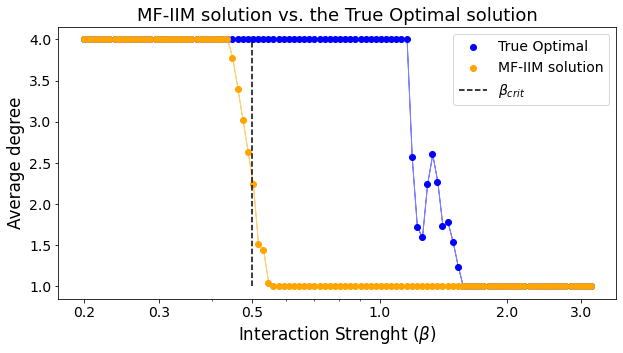

In [73]:
import matplotlib


avs_deg_theory=np.zeros(len(mean_th_run))
var_deg_theory = np.zeros(len(mean_th_run))
for it,control in enumerate(mean_th_run):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    variance_degree = np.sum([G.degree[i]**2*var for i,var in enumerate(var_th_run[it])])
    avs_deg_theory[it]=average_degree
    var_deg_theory[it]=variance_degree

    
matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(10,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


    
fig,ax = plt.subplots()

ax.scatter(beta_list,avs_deg_theory,label='True Optimal',c='blue')
ax.fill_between(beta_list, avs_deg_theory-np.sqrt(var_deg_theory), avs_deg_theory+np.sqrt(var_deg_theory),
                    **{'color':'blue','alpha':0.5})




ax.scatter(exp_beta_list,avs_deg,label='MF-IIM solution',c='orange')
ax.fill_between(exp_beta_list, avs_deg-np.sqrt(var_deg), avs_deg+np.sqrt(var_deg),
                    **{'color':'orange','alpha':0.5})


ax.vlines(beta_crit,ymin=1,ymax=4,linestyles='dashed',color='black',label=r'$\beta_{crit}$')

ax.legend()
ax.set_xscale(value='log')
ax.set_title('MF-IIM solution vs. the True Optimal solution')

ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght ($\beta$)')
plt.show()

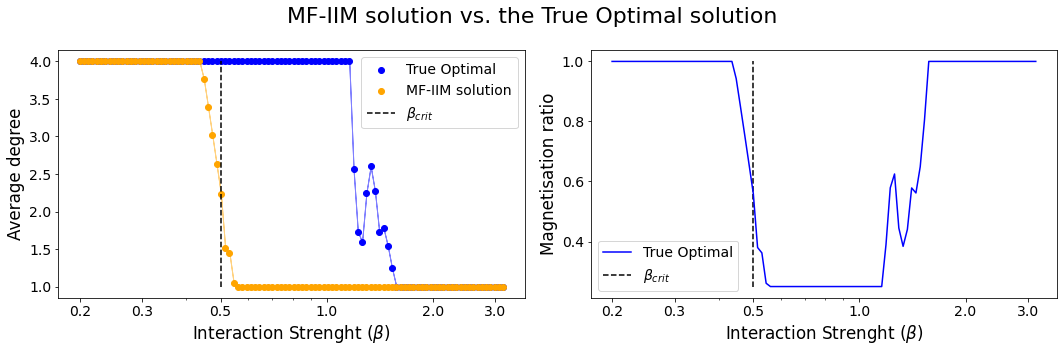

In [74]:
fig,ax = plt.subplots(figsize=(15,5),ncols=2)


ax[0].scatter(beta_list,avs_deg_theory,label='True Optimal',c='blue')
ax[0].fill_between(beta_list, avs_deg_theory-np.sqrt(var_deg_theory), avs_deg_theory+np.sqrt(var_deg_theory),
                    **{'color':'blue','alpha':0.5})




ax[0].scatter(exp_beta_list,avs_deg,label='MF-IIM solution',c='orange')
ax[0].fill_between(exp_beta_list, avs_deg-np.sqrt(var_deg), avs_deg+np.sqrt(var_deg),
                    **{'color':'orange','alpha':0.5})


ax[0].vlines(beta_crit,ymin=1,ymax=4,linestyles='dashed',color='black',label=r'$\beta_{crit}$')

ax[0].legend()
ax[0].set_xscale(value='log')

ax[0].set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].set_ylabel('Average degree')
ax[0].set_xlabel(r'Interaction Strenght ($\beta$)')



ax[1].plot(beta_list,avs_deg/avs_deg_theory,label='True Optimal',c='blue')

ax[1].vlines(beta_crit,ymin=min(avs_deg/avs_deg_theory),ymax=max(avs_deg/avs_deg_theory),linestyles='dashed',color='black',label=r'$\beta_{crit}$')

ax[1].legend()
ax[1].set_xscale(value='log')


ax[1].set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].set_ylabel('Magnetisation ratio')
ax[1].set_xlabel(r'Interaction Strenght ($\beta$)')

fig.suptitle('MF-IIM solution vs. the True Optimal solution',fontsize=22)


plt.tight_layout()

plt.show()

In [ ]:
xarray=np.linspace(0,budget,100)
xarray